In [9]:
import random
import os
import csv
from dataclasses import dataclass
import time

import torch
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [10]:
# Set device and CPU threads
from multiprocessing import cpu_count
torch.set_num_threads(cpu_count())
print(f'Using {torch.get_num_threads()} threads')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device {device}')

Using 32 threads
Using device cuda:0


In [11]:
# Tokenizer
NOTES = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
NOT_VOICE_TOKEN = '<N>'
END_OF_FILE_TOKEN = '<EOF>'

ALLOWED_TOKENS = []
for octave in [2,3,4,5]:
    o = str(octave)
    for n in NOTES:
        ALLOWED_TOKENS.append(n+o)

stoi = {s:i+1 for i,s in enumerate(ALLOWED_TOKENS)}
stoi[NOT_VOICE_TOKEN] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [12]:
# 30 seconds of data + around 87 pitch readings per second = 2610 -> make it 2700
BLOCK_SIZE = 87 * 30 + 90

In [13]:
# CLASS NAMES - NOTE: Do not change numbering.
CLASS_NAMES = {
    'saveri': 0,
    'hemavati': 1
}

In [14]:
@dataclass
class PitchDataFile:
    file_path: str
    pitches: list
    

In [15]:
# For initial tests, keep entire data in memory. Keep only the pitch list.
pitch_data_dir = '../../data/simple-test/pitch_data'

X = []
pitch_data = {}

for class_name in os.listdir(pitch_data_dir):
    if class_name not in CLASS_NAMES:
        print(f'{class_name} not included for training')
        continue
    class_dir = os.path.join(pitch_data_dir, class_name)
    for file_name in os.listdir(class_dir):
        file_path = os.path.join(class_dir, file_name)
        data = []
        print(f'processing {file_path}')
        with open(file_path, 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                if len(row) >= 3:
                    data.append(row[2])
            pd = PitchDataFile(file_path=file_path, pitches=[stoi[x] for x in data])
            sampling_data = [(file_path, i, CLASS_NAMES[class_name]) for i in range(len(data) - BLOCK_SIZE - 1)]
            X.extend(sampling_data)
            pitch_data[file_path] = pd

print(f'Total data: {len(X)}')

processing ../../data/simple-test/pitch_data/hemavati/aruna-hemavati_F3
processing ../../data/simple-test/pitch_data/hemavati/aruna-hemavati_F3_plus_3
processing ../../data/simple-test/pitch_data/hemavati/aruna-hemavati_F3_minus_1
processing ../../data/simple-test/pitch_data/hemavati/aruna-hemavati_F3_minus_2
processing ../../data/simple-test/pitch_data/hemavati/aruna-hemavati_F3_plus_2
processing ../../data/simple-test/pitch_data/hemavati/aruna-hemavati_F3_plus_1
processing ../../data/simple-test/pitch_data/saveri/tmk-saveri_D3_plus_2
processing ../../data/simple-test/pitch_data/saveri/tmk-saveri_D3_plus_3
processing ../../data/simple-test/pitch_data/saveri/tmk-saveri_D3_plus_1
processing ../../data/simple-test/pitch_data/saveri/tmk-saveri_D3
processing ../../data/simple-test/pitch_data/saveri/tmk-saveri_D3_minus_2
processing ../../data/simple-test/pitch_data/saveri/tmk-saveri_D3_minus_1
Total data: 1844748


In [16]:
random.shuffle(X)
train_size = int(0.8 * len(X))
dev_size = int(0.1 * len(X))

# Split the data
train = X[:train_size]
dev = X[train_size:train_size + dev_size]
test = X[train_size + dev_size:]

Xtrain, Ytrain = [tuple(t[:2]) for t in train], [t[2] for t in train]
Xdev, Ydev = [tuple(t[:2]) for t in dev], [t[2] for t in dev]
Xtest, Ytest = [tuple(t[:2]) for t in test], [t[2] for t in test]

Ytrain = torch.tensor(Ytrain, device=device)
Ydev = torch.tensor(Ydev, device=device)
Ytest = torch.tensor(Ytest, device=device)

print(f'Xtrain size: {len(Xtrain)}, Ytrain size: {len(Ytrain)}')
print(f'Xdev size: {len(Xdev)}, Ydev size: {len(Ydev)}')
print(f'Xtest size: {len(Xtest)}, Ytest size: {len(Ytest)}')

Xtrain size: 1475798, Ytrain size: 1475798
Xdev size: 184474, Ydev size: 184474
Xtest size: 184476, Ytest size: 184476


In [17]:
print(Xtrain[2:4])
print(Ytrain[2:4])

[('../../data/simple-test/pitch_data/saveri/tmk-saveri_D3_plus_1', 76968), ('../../data/simple-test/pitch_data/hemavati/aruna-hemavati_F3_plus_3', 100173)]
tensor([0, 1], device='cuda:0')


In [18]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet_1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, n_embd, n_tokens, device='cpu', dropout=0.1):
        super().__init__()
        self.emb = nn.Embedding(n_tokens, n_embd, device=device)
        self.ConvNet = nn.Sequential(
            nn.Conv1d(n_embd, 32, kernel_size=kernel_size, device=device),
            nn.ReLU(),
            nn.BatchNorm1d(32, device=device),
            nn.MaxPool1d(kernel_size=5),

            nn.Conv1d(32, 64, kernel_size=kernel_size, device=device),
            nn.ReLU(),
            nn.BatchNorm1d(64, device=device),
            nn.MaxPool1d(kernel_size=5),

            nn.Conv1d(64, 128, kernel_size=kernel_size, device=device),
            nn.ReLU(),
            nn.BatchNorm1d(128, device=device),
            nn.MaxPool1d(kernel_size=5),

            nn.Conv1d(128, 256, kernel_size=kernel_size, device=device),
            nn.ReLU(),
            nn.BatchNorm1d(256, device=device),
            nn.MaxPool1d(kernel_size=5),
            nn.Dropout(dropout),

            nn.Flatten()
        )

         #Fully connected layers for regression or classification
        self.task = nn.Sequential(
            nn.Linear(768, 100, device=device),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(100, out_channels, device=device)
        )

    def calculate_output_size(self, in_channels, kernel_size, stride, padding):
        # Calculate the output size after multiple convolutional and pooling layers
        output_size = (in_channels - kernel_size + 2 * padding) // stride + 1
        #print(f'output_size {output_size}')
        output_size = (output_size - kernel_size + 2 * padding) // stride + 1
        #print(f'output_size {output_size}')
        output_size = (output_size - kernel_size + 2 * padding) // stride + 1
        #print(f'output_size {output_size}')
        output_size = (output_size - kernel_size + 2 * padding) // stride + 1
        #print(f'output_size {output_size}')
        return output_size

    def forward(self, x):
        x = self.emb(x)
        sequence_length = x.shape[2]
        minibatch_length = x.shape[0]
        x = x.view(minibatch_length, sequence_length, -1)
        x = self.ConvNet(x)
        output = self.task(x)
        return output

In [34]:
def fetch_data(xtr, idx):
    tmp = []
    for i in idx:
        file_path = xtr[i][0]
        start_index = xtr[i][1]
        v = pitch_data[file_path].pitches[start_index:start_index+BLOCK_SIZE]
        tmp.append(pitch_data[file_path].pitches[start_index:start_index+BLOCK_SIZE])
    return torch.tensor(tmp, device=device)

def save_model(path:str, model, optimizer, epochs, train_loss, val_loss):
    torch.save({
        'epochs': epochs,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)

In [56]:
# Example usage
in_channels = 1  # Input channels (e.g., single-channel audio)
out_channels = 2  # Output channels (e.g., regression output)
kernel_size = 3   # Kernel size
stride = 1       # Stride
padding = 0      # Padding
n_tokens = vocab_size
n_embd = 24

# Learning rate
lr = 0.001
epochs = 0
model = ConvNet_1D(in_channels, out_channels, kernel_size, n_embd, n_tokens, device=device)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

MODEL_PATH = '../models/simple-test-model'
if os.path.exists(MODEL_PATH):
    checkpoint = torch.load(MODEL_PATH)
    epochs = checkpoint['epochs']
    train_loss = checkpoint['train_loss']
    val_loss = checkpoint['val_loss']
    print(f'checkpoint after epoch: {epochs}')
    print(f'train loss: {train_loss}')
    print(f'val loss: {val_loss}')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    model.train()
# Example input - First dimension is number of minibatches, second is embedding dimension, third is context size
#input_tensor = torch.randint(0, n_tokens, (32, 2700), device=device)  # Batch size, channels, sequence length
#logits = model(input_tensor)
#loss = F.cross_entropy(logits, torch.randint(0, out_channels, (32,), device=device))
#print(f'output shape {output.shape}')
#print(f'logits: {logits.shape}')
#print(f'loss: {loss}')
#total_params = sum(param.numel() for param in model.parameters())
#print(f'total params {total_params}')

#for p in model.parameters():
#    p.grad = None
#loss.backward()   

checkpoint after epoch: 5000
train loss: 0.07603889085091521
val loss: 0.08229112236511257


/tmp/ipykernel_6032/615128569.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH)


In [53]:
max_steps = 1000
batch_size = 32
lossi = []
ud = []

for i in range(epochs, epochs + max_steps):
    start_time = time.time()
    # minibatch construct
    ix = torch.randint(0, len(Xtrain), (batch_size,))
    Xb, Yb = fetch_data(Xtrain, ix), Ytrain[ix] # batch X,Y
    #print(f'time for minibatching {time.time() - start_time}')
      
    #start_time = time.time()
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function
    #print(f'time for forward pass {time.time() - start_time}')
    
    # backward pass
    #start_time = time.time()
    #for p in model.parameters():
    #    p.grad = None
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #print(f'time for backward pass {time.time() - start_time}')
  
    # update: simple SGD
    #lr = 0.1 if i < 1500 else 0.01 # step learning rate decay
    #for p in model.parameters():
    #    p.data += -lr * p.grad

    # track stats
    epochs += 1
    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{epochs + max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in model.parameters()])

   4000/   5001: 0.0416


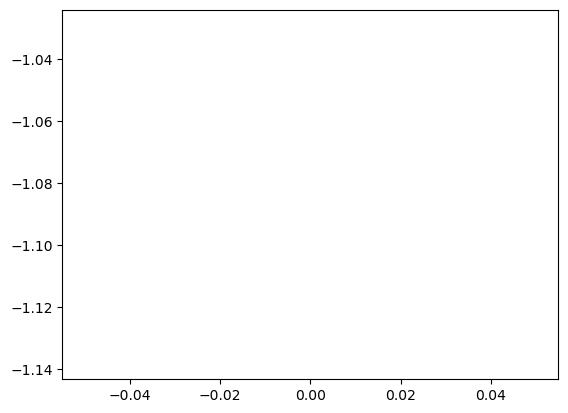

In [48]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

weight (32, 24, 3) | mean -0.000474 | std 2.321290e-02 | grad:data ratio 2.637677e-01
weight (64, 32, 3) | mean +0.000418 | std 1.313264e-02 | grad:data ratio 1.606191e-01
weight (128, 64, 3) | mean -0.000675 | std 3.402344e-03 | grad:data ratio 5.177137e-02
weight (256, 128, 3) | mean +0.000022 | std 7.575457e-04 | grad:data ratio 1.423154e-02


/tmp/ipykernel_6032/2606801353.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hy, hx = torch.histogram(torch.tensor(t, device='cpu'), density=True)


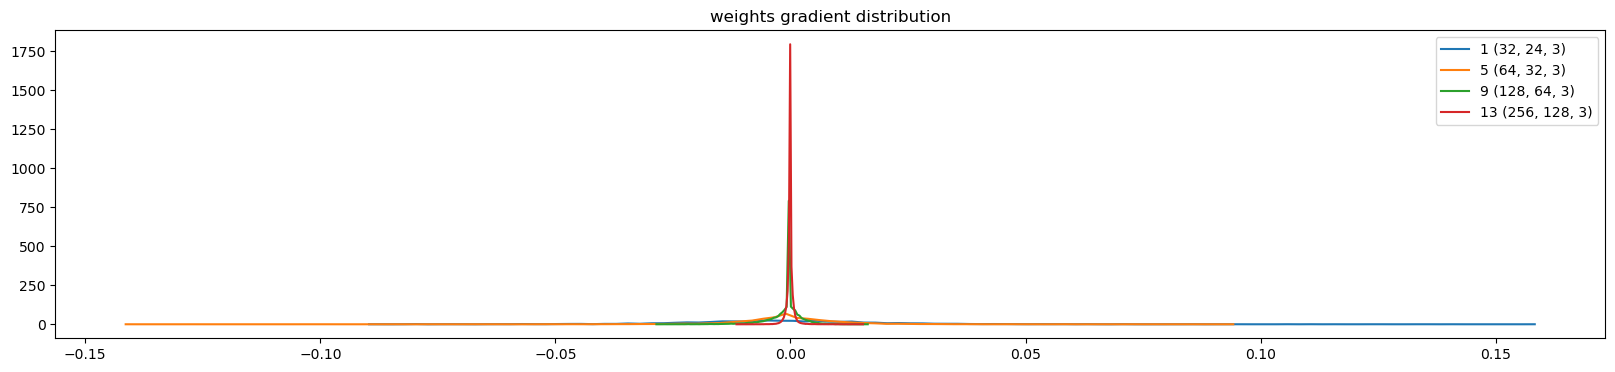

In [49]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(model.parameters()):
    t = p.grad
    # Conv1D
    if p.ndim == 3:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(torch.tensor(t, device='cpu'), density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

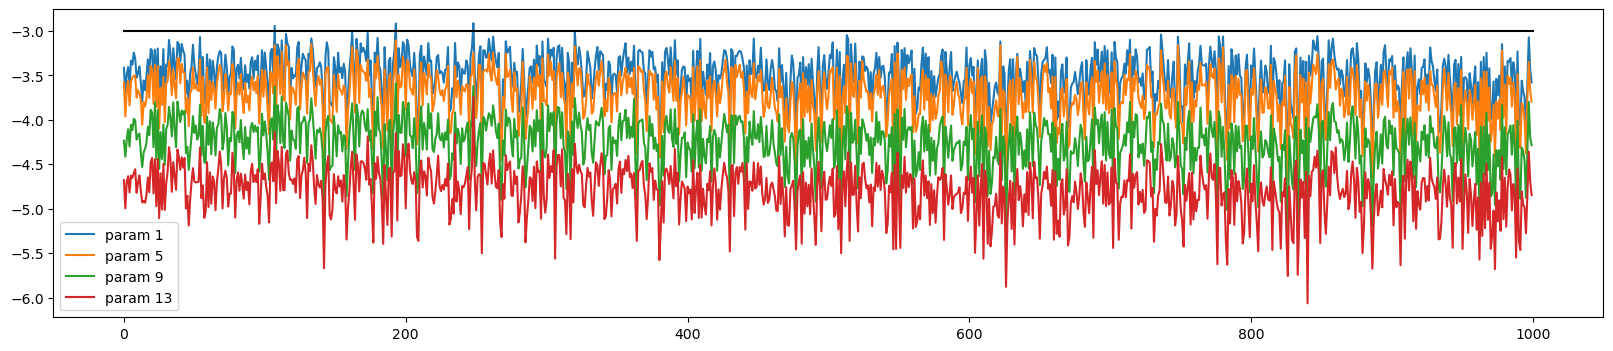

In [50]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(model.parameters()):
    # Conv1D
    if p.ndim == 3:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [51]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
        'train': (Xtrain, Ytrain),
        'val': (Xdev, Ydev),
        'test': (Xtest, Ytest),
    }[split]
    total_loss = 0
    count = 0
    for i in range(0, len(x), 256):
        if i > len(x):
            break
        logits = model(fetch_data(x, [k for k in range(i, min(i + 32, len(x)))]))
        loss = F.cross_entropy(logits, y[i:min(i + 32, len(x))])
        total_loss += loss.item()
        count += 1
    return total_loss / count

model.eval()
train_loss = split_loss('train')
print(f'train loss: {train_loss}')
val_loss = split_loss('val')
print(f'val loss: {val_loss}')
model.train()

train loss: 0.07603889085091521
val loss: 0.08229112236511257


ConvNet_1D(
  (emb): Embedding(49, 24)
  (ConvNet): Sequential(
    (0): Conv1d(24, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
    (9): ReLU()
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
    (13): ReLU()
    (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): MaxPool1d(kernel_size=5,

In [54]:
MODEL_PATH = '../models/simple-test-model'
save_model(MODEL_PATH, model, optimizer, epochs, train_loss, val_loss)